<a href="https://colab.research.google.com/github/JeJaMel/Detection-and-classification-of-waste-with-AI-and-artificial-vision/blob/main/detection_and_classification_of_waste_with_AI_and_artificial_vision_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detection and classification of waste with Ai and artificial vision project

##0. Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.test.gpu_device_name() #this line is for test if T4 GPUT is beeing used (recomend)
import kagglehub
from google.colab import drive
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import layers
import pandas as pd
import cv2
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint
import streamlit as st
from pyngrok import ngrok
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model


##1. Dataset preparation

##1.1 Import the dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

100%|██████████| 40.8M/40.8M [00:00<00:00, 88.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1 /content/drive/MyDrive/trashnet #Move the dataset to the drive


In [ ]:
!pip install pyngrok streamlit

##1.2 Data cleaning

In this project, is not really necesary the data cleaning, because when we import the dataset with kagglehub, are usually already resized (at least in the TrashNet dataset) the images are already resized, However, we will go through the process anyway to demonstrate it.

In [ ]:
#Dataset route
DATASET_PATH = '/content/drive/MyDrive/trashnet/dataset-resized'

First i am going to filter the images to delete all the images that are not JPEG

In [ ]:
def filter_images():
  deleted_imgs = 0
  for folder_name in ("cardboard", "glass", "metal", "paper", "plastic", "trash"):
    folder_path = os.path.join(DATASET_PATH, folder_name)
    for image in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image)
        try:
            fobj = open(img_path, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            deleted_imgs += 1
            os.remove(img_path)
  print(f"Deleted Images: {deleted_imgs}")

In [ ]:
filter_images() #the function executes, in this case there's 0 images deleted.

With this block of code we can see the dimensions of our images, in TrashNet all the dataset dimensions are 384x512

In [ ]:
plt.figure(figsize=(10, 10))

folder_path = os.path.join(DATASET_PATH, "paper")
for i, image in enumerate(os.listdir(folder_path)[:9]):
  img_path = os.path.join(folder_path, image)
  img = mpimg.imread(img_path)
  ax = plt.subplot(3, 3, i + 1) #(nrows, ncols, index)
  plt.imshow(img)
  plt.title(f"Size: {img.shape[:2][0]} x {img.shape[:2][1]} pixels")
  plt.axis("off")

plt.show()

##1.3 Creating a dataset with keras

With keras we can normalize the dimensions of the images, using functions that convert our data to an Dataset object

Tensorflow: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [ ]:
image_size = (224, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,  #30% of the images will make part of the validation ds
    subset="training",
    seed=1330,
    image_size=image_size,
    batch_size=batch_size,
)

We verify the size again

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Size: {images[i].shape[0]} x {images[i].shape[1]} pixels")
        plt.axis("off")

plt.show()

Here we can see al the batch especifications:


In [ ]:
batch1 = list(train_ds.take(1))
print(f"Number of batches: {len(train_ds)}")
print(f"Number of images in batch: {len(batch1[0][0])}")
print(f"labels of batch: {batch1[0][1]}")

Number of batches: 64
Number of images in batch: 32
labels of batch: [1 3 3 1 0 4 2 3 3 3 0 4 3 0 1 2 3 3 0 0 0 4 4 3 4 3 4 1 4 0 2 0]


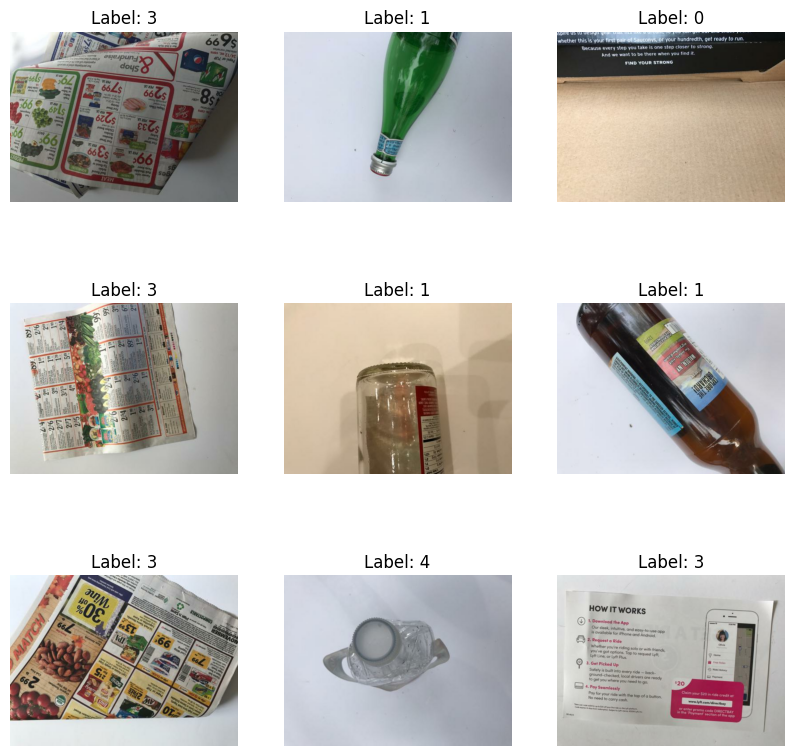

In [ ]:
#here we can see the images with their respective label
plt.figure(figsize=(10, 10))

for img, etiqueta in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(f"Label: {etiqueta[i]}")
    plt.axis("off")

plt.show()

##1.5 Splitting the dataset

When we approach the resolution of a real problem by applying Artificial Intelligence / Machine Learning / Deep Learning, we must divide the data set into 3 subsets:


*  Training subset (```train_ds```): Contains approximately 60-80% of the data. This subset is used to train the algorithm.
*  Validation subset (```val_ds```): Contains approximately 10-20% of the data. This subset is used to validate the behavior of the algorithm during the training process.
*  Test subset (```test_ds```): Contains approximately 10-20% of the data. This subset will be used to validate the behavior of the final trained algorithm. Its role is to determine whether the model behaves correctly for examples it has never seen before.

In this case i will split the data in a 80/10/10 proportion

In [ ]:
# Obtain the validation subset
temp_val_ds = keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,  # 30%
    subset="validation",
    seed=1330,
    image_size=image_size,
    batch_size=batch_size,
)

Now that we have the validation subset created from 20% of the data, we will divide it in half to get the test subset.

In [ ]:
len(temp_val_ds)

In [ ]:
val_size = int(0.5 * len(temp_val_ds))
val_size

In [ ]:
val_ds = temp_val_ds.take(val_size)
test_ds = temp_val_ds.skip(val_size)

In [ ]:
len(val_ds)

In [ ]:
len(test_ds)

##1.6 Data augmentation

Before we start creating the architecture of our articial neural network, we are going to implement a technique to enlarge our dataset called Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomBrightness(factor=0.2),
        layers.Resizing(224, 224)
    ]
)

Here we can see the new images added

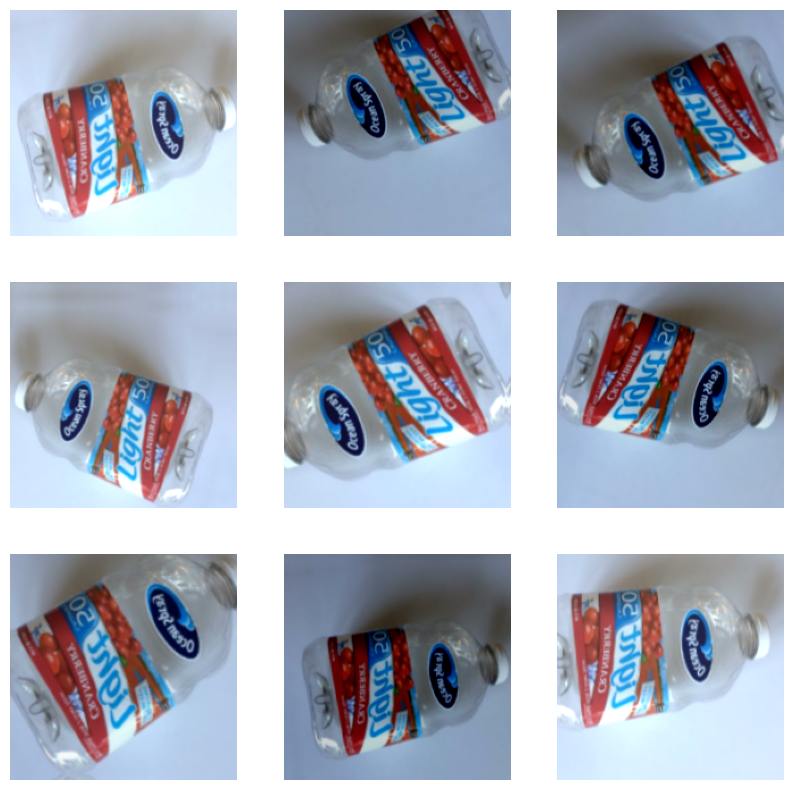

In [ ]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Finally we implement "data augmentation" to train_ds
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, training=True), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

##2. Definition of the architecture of the Artificial Neural Network

For the architecture, i will use MobilNetV2

The architecture is graphically represented in the report

In [ ]:
def make_mobilenetv2_model(input_shape, num_classes):
    base_model = keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,  # Exclude the original classifier
        weights="imagenet"  # Use pre-trained weights
    )

    # Freeze the base model for transfer learning
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)

    # Normalize input
    x = layers.Rescaling(1.0 / 255)(inputs)

    # Use MobileNetV2 as feature extractor
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)  # Reduce feature maps to a vector

    # Add dropout for regularization
    x = layers.Dropout(0.5)(x)

    # Output layer
    activation = "softmax" if num_classes > 2 else "sigmoid"
    outputs = layers.Dense(num_classes, activation=activation)(x)

    return keras.Model(inputs, outputs)


In [ ]:
mobilenetv2 = make_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=6)

In [ ]:
mobilenetv2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           7,686 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

##3. Configuration of the Artificial Neural Network

For the Artificial Neural Network to work properly it will require three additional components that are selected during the compilation process:

*   Error function
*   Optimization fuction
*   Metrics to monitor the training process

In [ ]:
mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Lower LR for transfer learning
    loss="sparse_categorical_crossentropy",  # For multi-class classification (6 classes)
    metrics=["accuracy"]  # Track accuracy
)



In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
]


##4. Training the model

At this point we are ready to train our Artificial Neural Network by invoking the ```fit()``` method. One of the capabilities that Keras provides us is to integrate the validation process into the training process itself. To do this, together with the training data subset, we must provide this method with the validation subset.

In [ ]:
history = mobilenetv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # Start with 20, adjust based on results
    callbacks=callbacks
)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

Fine-tune the model

In [ ]:
# Unfreeze the entire base model for fine-tuning (or selectively unfreeze layers)
mobilenetv2.layers[0].trainable = True

In [ ]:
mobilenetv2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss="sparse_categorical_crossentropy",  # Same loss for multi-class classification
    metrics=["accuracy"]
)


In [ ]:
history_finetune = mobilenetv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Continue training for more epochs, adjust as necessary
    callbacks=callbacks
)


In [ ]:
pd.DataFrame(history_finetune.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

##5. Save the model


In [ ]:
# Save the entire model (architecture, weights, optimizer, etc.)
mobilenetv2.save('/content/drive/MyDrive/trashnet/trainedTrashNetV11(not the best).h5')


In [ ]:
# Load the model from the saved file
mobilenetv2 = load_model('/content/drive/MyDrive/trashnet/best_modelV2.h5')


#6. Test model with new examples

In [ ]:
# We test the model with test_ds, images that mobilenetv2 never seen befote
evaluation_result = mobilenetv2.evaluate(test_ds)

print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7740 - loss: 0.6079
Loss: 0.5889435410499573
Accuracy: 0.7834224700927734


In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = mobilenetv2.predict(tf.expand_dims(images[i], 0))
        # Get predicted class index
        predicted_class = predictions.argmax()
        # Get probability of predicted class
        score = predictions[0][predicted_class]
        class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        plt.title(f": {class_names[predicted_class]}, Confidence: {100 * score:.2f}%")
        plt.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


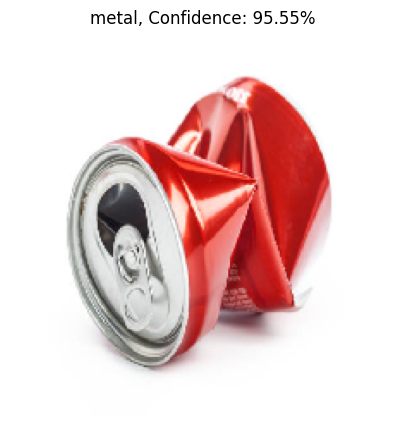

In [ ]:
img_path = 'PATH_TO_IMAGE' #Also testing with an image that was never seen before
img = image.load_img(img_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_array = tf.expand_dims(img_array, axis=0)

predictions = mobilenetv2.predict(img_array)

predicted_class = predictions.argmax()

score = predictions[0][predicted_class]

# Classes name
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title(f"{class_names[predicted_class]}, Confidence: {100 * score:.2f}%")
plt.axis("off")
plt.show()

This code is for setup an web servir with streamlit and ngrok

In [ ]:
ngrok.set_auth_token("NGROK_TOKEN")

# Configure the tunnel using a config object
tunnel = ngrok.connect(addr="8501", proto="http", bind_tls=True)  # Streamlit's default port

public_url = tunnel.public_url
print(f"Public URL: {public_url}")

# Start the Streamlit server, pointing to your script file
!streamlit run --server.port 8501 /content/drive/MyDrive/trashnet/python_script/main.py &